# Quantum layer activation visualization

In [1]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import copy

env: OMP_NUM_THREADS=1


## Hyperparameter setup

In [2]:
filtered_classes = ['cat', 'dog']  # Subset of CIFAR ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_qubits = 4                       # Number of qubits
                                   # An enterily classical net (defined by the next parameter). 
classical_model = '512_nq_n'          # Possible choices: '512_n','512_nq_n','551_512_n'. [nq=n_qubits, n=num_filtered_classes]
step = 0.001                       # Learning rate
batch_size = 256                   # Number of samples for each training step
num_epochs = 3                     # Number of training epochs
q_depth = 5                        # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 1             # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                    # Keep 15 even if not all are used.
q_delta = 0.01                     # Initial spread of random quantum weights
rng_seed = 0                       # Seed for random number generator
start_time = time.time()           # start of the computation timer

In [3]:
torch.manual_seed(rng_seed)
dev = qml.device('default.qubit', wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

## Hybrid transfer learning model (classical-to-quantum).

In [4]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): # Loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1,2): # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [5]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)
        
        # Embed features in the quantum node
        RY_layer(q_in)
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k+1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [6]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, len(filtered_classes))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch, and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

In [7]:
class Quantumnet_Cut(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch, and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return q_out

In [8]:
class Quantumnet_Classical_Cut(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   

            return q_in

In [9]:
# Build Hybrid Model
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

model_hybrid.fc = Quantumnet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [10]:
model_classical_cut = torchvision.models.resnet18(pretrained=True)

model_classical_cut.fc = Quantumnet_Classical_Cut()

for param in model_classical_cut.parameters():
    param.requires_grad = False

# Use CUDA or CPU according to the "device" object.
model_classical_cut = model_classical_cut.to(device)

In [11]:
model_cut = torchvision.models.resnet18(pretrained=True)

model_cut.fc = Quantumnet_Cut()

for param in model_cut.parameters():
    param.requires_grad = False

# Use CUDA or CPU according to the "device" object.
model_cut = model_cut.to(device)

## Load model from file

In [ ]:
# Load model from file
path = './'
model_hybrid.load_state_dict(torch.load(path+'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'))

In [ ]:
model_dict = model_hybrid.state_dict()

model_cut_dict = model_cut.state_dict()
model_cut_dict = {k: v for k, v in model_dict.items() if k in model_cut_dict}
model_cut.load_state_dict(model_cut_dict)

model_classical_cut_dict = model_classical_cut.state_dict()
model_classical_cut_dict = {k: v for k, v in model_dict.items() if k in model_classical_cut_dict}
model_classical_cut.load_state_dict(model_classical_cut_dict)

## Dataset loading

In [14]:
# Fixed pre-processing operations
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# =================== begin CIFAR dataset loading ===================
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
image_datasets_full={'train': trainset_full, 'val': testset_full}

# CIFAR classes
class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get indices of samples associated to filtered_classes
filtered_labels=[class_names.index(cl) for cl in filtered_classes]
sub_indices={'train': [], 'val': []}
for phase in ['train', 'val']:
    for idx, label in enumerate(image_datasets_full[phase].targets):  
        if label in filtered_labels:
            sub_indices[phase].append(idx)
            
# Initialize sub-datasets according to filtered indices
image_datasets = {x: torch.utils.data.Subset(image_datasets_full[x], sub_indices[x])
                for x in ['train', 'val']}

def labels_to_filtered(labels):
    """Maps CIFAR labels (0,1,2,3,4,5,6,7,8,9) to the index of filtered_labels"""
    return [filtered_labels.index(label) for label in labels]
# =================== end CIFAR dataset loading ==========================

# Number of samples
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Function to plot images from tensors
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

0it [00:00, ?it/s]

100%|█████████▉| 169926656/170498071 [00:56<00:00, 8128959.80it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [15]:
# Get a batch of training data
X, y_cifar = next(iter(dataloaders['val']))
y = torch.tensor(labels_to_filtered(y_cifar))
X, y = X.to(device), y.to(device)

170500096it [00:59, 2886231.09it/s]                               


In [16]:
# Slice Models
network = model_hybrid
layers = list(network.children())
hybrid_feats = []

for i in range(9):
    model_sliced = nn.Sequential(*layers[: i]) #Max: 9
    hybrid_feats.append(torch.flatten(model_sliced(X), 1, 3).detach().cpu().numpy())

hybrid_feats.append(model_classical_cut(X).detach().cpu().numpy())
hybrid_feats.append(model_cut(X).detach().cpu().numpy())

## Visualize the model - quantum layer activation

In [58]:
import umap.umap_ as umap

In [59]:
def normalize_layout(layout, min_percentile=1, max_percentile=99, relative_margin=0.1):
    """Removes outliers and scales layout to between [0,1]."""

    # compute percentiles
    mins = np.percentile(layout, min_percentile, axis=(0))
    maxs = np.percentile(layout, max_percentile, axis=(0))

    # add margins
    mins -= relative_margin * (maxs - mins)
    maxs += relative_margin * (maxs - mins)

    # `clip` broadcasts, `[None]`s added only for readability
    clipped = np.clip(layout, mins, maxs)

    # embed within [0,1] along both axes
    clipped -= clipped.min(axis=0)
    clipped /= clipped.max(axis=0)

    return clipped

In [76]:
layout = umap.UMAP(n_components=2, verbose=True, n_neighbors=20, min_dist=0.01, metric="cosine").fit_transform(result)

## You can optionally use TSNE as well
# layout = TSNE(n_components=2, verbose=True, metric="cosine", learning_rate=10, perplexity=50).fit_transform(d)

layout = normalize_layout(layout)

UMAP(angular_rp_forest=True, dens_frac=0.0, dens_lambda=0.0, metric='cosine',
     min_dist=0.01, n_neighbors=20, verbose=True)
Construct fuzzy simplicial set
Fri Feb 19 05:15:28 2021 Finding Nearest Neighbors
Fri Feb 19 05:15:28 2021 Finished Nearest Neighbor Search
Disconnection_distance = 1 has removed 6670 edges.  This is not a problem as no vertices were disconnected.
Fri Feb 19 05:15:28 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Feb 19 05:15:31 2021 Finished embedding


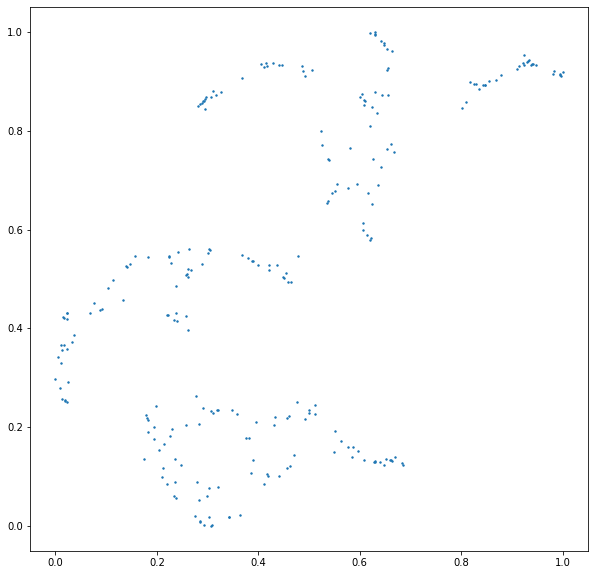

In [77]:
plt.figure(figsize=(10, 10))
plt.scatter(x=layout[:,0],y=layout[:,1], s=2)
plt.savefig('quantum_activation_result.png')

In [44]:
def whiten(full_activations):
    correl = np.matmul(full_activations.T, full_activations) / len(full_activations)
    correl = correl.astype("float32")
    S = np.linalg.inv(correl)
    S = S.astype("float32")
    return S

In [79]:
S = whiten(result)

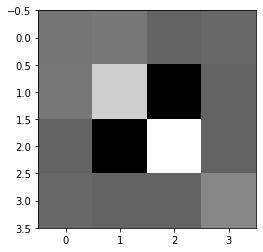

In [80]:
plt.imshow(S, cmap='gray')
plt.savefig('quantum_activation_whitening.png')